<a href="https://colab.research.google.com/github/liliakurghinyan/meteorite_project/blob/main/meteorite_landings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project: Meteorite Landings Prediction and Analysis**

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.preprocessing import LabelEncoder
from math import radians,sin,cos,sqrt,asin

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor



%matplotlib inline

In [2]:
meteorite_df = pd.read_csv('/content/NASA_DATA/Meteorite_Landings_20241015.csv')
meteorite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [3]:
meteorite_df.describe()

,id,mass (g),year,reclat,reclong
count,45716.000000,4.558500e+04,45425.000000,38401.000000,38401.000000
mean,26889.735104,1.327808e+04,1991.828817,-39.122580,61.074319
std,16860.683030,5.749889e+05,25.052766,46.378511,80.647298
min,1.000000,0.000000e+00,860.000000,-87.366670,-165.433330
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670
max,57458.000000,6.000000e+07,2101.000000,81.166670,354.473330


In [4]:
meteorite_df.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


**Data Cleaning and Preparation**

In [5]:
meteorite_df.isnull().any()

,0
name,False
id,False
nametype,False
recclass,False
mass (g),True
fall,False
year,True
reclat,True
reclong,True
GeoLocation,True


In [6]:
meteorite_df.isnull().sum()

,0
name,0
id,0
nametype,0
recclass,0
mass (g),131
fall,0
year,291
reclat,7315
reclong,7315
GeoLocation,7315


droping every row, where is even one null value

In [7]:
meteorite_df=meteorite_df.dropna(how='any')
meteorite_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38115 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         38115 non-null  object 
 1   id           38115 non-null  int64  
 2   nametype     38115 non-null  object 
 3   recclass     38115 non-null  object 
 4   mass (g)     38115 non-null  float64
 5   fall         38115 non-null  object 
 6   year         38115 non-null  float64
 7   reclat       38115 non-null  float64
 8   reclong      38115 non-null  float64
 9   GeoLocation  38115 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.2+ MB


checking if there are any duplicated values

In [8]:
meteorite_df.duplicated().sum()

0

In [9]:
meteorite_df.rename(columns={'mass (g)':'mass'},inplace=True)

# **Exploratory Data Analysis (EDA)**

Analyze the geographical distribution of meteorite landings (plot using folium or geopandas).

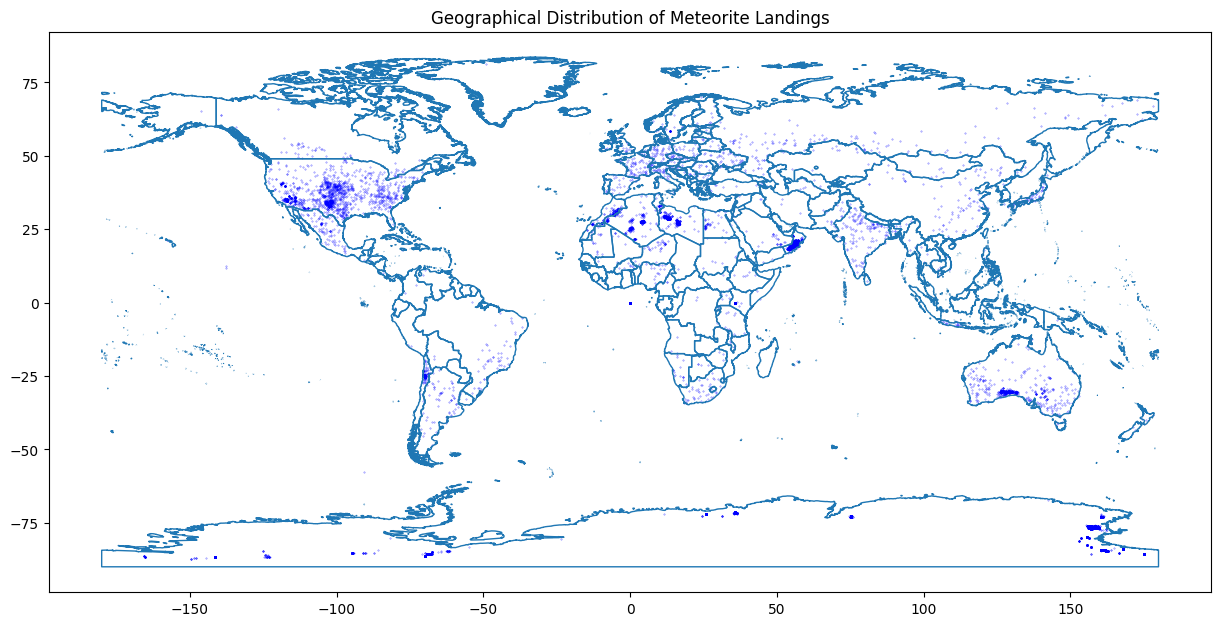

In [10]:
gdf = gpd.GeoDataFrame(meteorite_df, geometry=gpd.points_from_xy(meteorite_df['reclong'],meteorite_df['reclat']))

world= gpd.read_file('/content/NASA_DATA/ne_10m_admin_0_countries.shp')

fig, ax = plt.subplots(figsize=(15,10))
world.boundary.plot(ax=ax,linewidth=1)
gdf.plot(ax=ax,color='blue',markersize=0.1,alpha=0.6)
plt.title('Geographical Distribution of Meteorite Landings')
plt.show()

Study the correlation between meteorite size, type, and year of landing.

Recclass column is a string type column, i wnted to find correlation between recclass, size and year, but i couldn't use recclass there, so i made new feature called 'recclass_compacted' that groups unique recclasses under the same value. It is numeric type column, feature so it's going to be easy to work with it.

In [11]:
meteorite_df['recclass'].nunique()

# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder to the unique values in 'recclass' and transform the column
meteorite_df['recclass_compacted'] = encoder.fit_transform(meteorite_df['recclass'])



In [12]:
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(mapping) # shows all unique recclass with their compacted value.

{'Acapulcoite': 0, 'Acapulcoite/Lodranite': 1, 'Acapulcoite/lodranite': 2, 'Achondrite-prim': 3, 'Achondrite-ung': 4, 'Angrite': 5, 'Aubrite': 6, 'Aubrite-an': 7, 'Brachinite': 8, 'C': 9, 'C1/2-ung': 10, 'C2': 11, 'C2-ung': 12, 'C3-ung': 13, 'C3.0-ung': 14, 'C4': 15, 'C4-ung': 16, 'C4/5': 17, 'C5/6-ung': 18, 'C6': 19, 'CB': 20, 'CBa': 21, 'CBb': 22, 'CH/CBb': 23, 'CH3': 24, 'CI1': 25, 'CK': 26, 'CK3': 27, 'CK3-an': 28, 'CK4': 29, 'CK4-an': 30, 'CK4/5': 31, 'CK5': 32, 'CK5/6': 33, 'CK6': 34, 'CM': 35, 'CM-an': 36, 'CM1': 37, 'CM1/2': 38, 'CM2': 39, 'CO3': 40, 'CO3.0': 41, 'CO3.1': 42, 'CO3.2': 43, 'CO3.3': 44, 'CO3.4': 45, 'CO3.5': 46, 'CO3.6': 47, 'CO3.7': 48, 'CO3.8': 49, 'CR': 50, 'CR-an': 51, 'CR1': 52, 'CR2': 53, 'CR2-an': 54, 'CR7': 55, 'CV2': 56, 'CV3': 57, 'CV3-an': 58, 'Chondrite-fusion crust': 59, 'Chondrite-ung': 60, 'Diogenite': 61, 'Diogenite-an': 62, 'Diogenite-olivine': 63, 'Diogenite-pm': 64, 'E': 65, 'E-an': 66, 'E3': 67, 'E3-an': 68, 'E4': 69, 'E5': 70, 'E5-an': 71, 'E

Making the correlation matrix

In [13]:
correlation_matrix = meteorite_df[['recclass_compacted','year','mass']].corr()
print(correlation_matrix)

                    recclass_compacted      year      mass
recclass_compacted            1.000000  0.061277 -0.005875
year                          0.061277  1.000000 -0.121905
mass                         -0.005875 -0.121905  1.000000


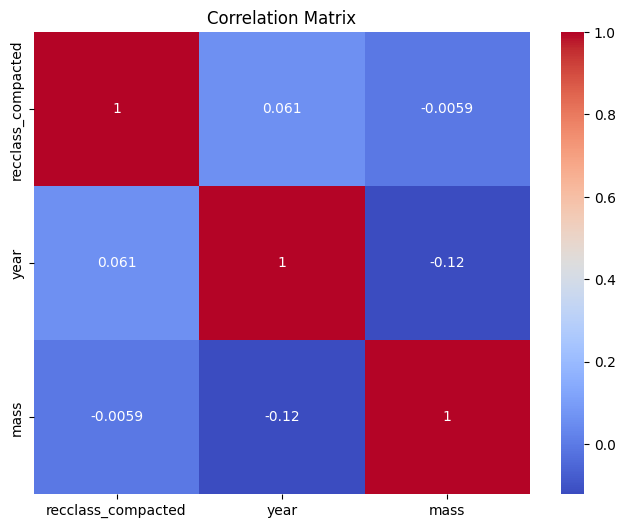

In [14]:
fig = plt.subplots(figsize=(8,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

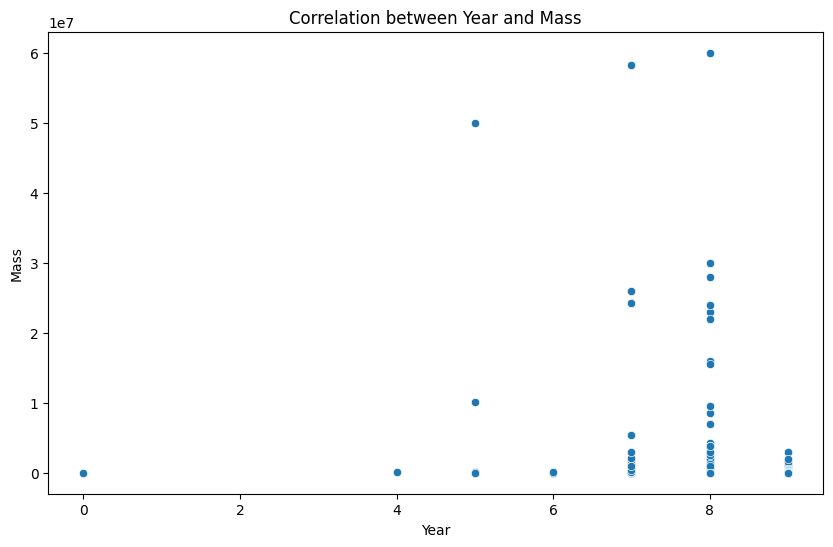

In [15]:
meteorite_df['year_cut'] = pd.cut(meteorite_df['year'], bins=10, labels=False)

figure = plt.subplots(figsize=(10,6))
sns.scatterplot(data=meteorite_df,x='year_cut',y='mass')
plt.title('Correlation between Year and Mass')
plt.xlabel('Year')
plt.ylabel('Mass')
plt.show()

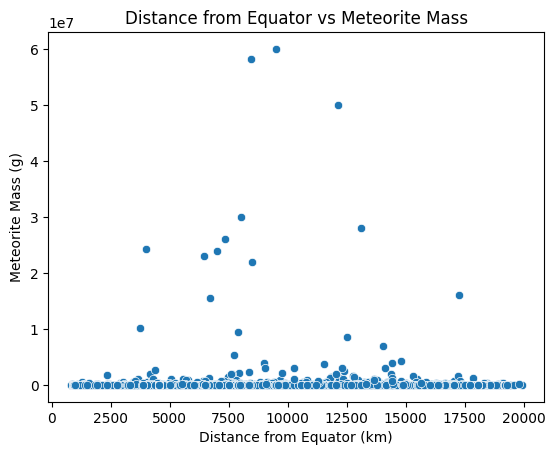

In [16]:
def haversine(lat1, lon1, lat2, lon2):
  la1,lon1,lat2,lon2 =map(radians,[lat1,lon1,lat2,lon2])

  # Haversine formula
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a))
  r = 6371  # Radius of earth in kilometers
  return c * r

#Yerevan's location
equator_lat = 40.177200
equator_lon = 44.503490

meteorite_df['distance_from_equator'] = meteorite_df.apply(lambda row: haversine(row['reclat'], row['reclong'], equator_lat, equator_lon), axis=1)


sns.scatterplot(data=meteorite_df, x='distance_from_equator', y='mass')
plt.title('Distance from Equator vs Meteorite Mass')
plt.xlabel('Distance from Equator (km)')
plt.ylabel('Meteorite Mass (g)')
plt.show()

In [17]:
# geolocator = Nominatim(user_agent="my-unique-geocoding-app") # Changed the user agent to be more unique and descriptive

# def get_country(lat, lon):
#     try:
#         location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
#         if location:
#             address = location.raw['address']
#             return address.get('country', 'Unknown')
#     except (GeocoderTimedOut, GeocoderServiceError) as e:  # Handle both timeout and service errors
#         print(f"Error geocoding ({lat}, {lon}): {e}")  # Print error details for debugging
#         return "Unknown"  # Return "Unknown" for failed geocoding attempts

#     return "Unknown"

# meteorite_df['country'] = meteorite_df.apply(lambda row: get_country(row['reclat'], row['reclong']), axis=1)
# meteorite_df.head()

In [22]:
X=meteorite_df[['year']]
Y=meteorite_df['mass']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print('Predicted values', Y_pred)
print('Actual values', Y_test.values)





Predicted values [2.48180743e+03 2.33661426e+02 6.11870025e+02 ... 1.31362344e+03
 5.06226582e+02 1.14503998e+06]
Actual values [1.134e+02 2.812e+01 6.200e+00 ... 1.180e+01 8.000e-01 4.173e+04]


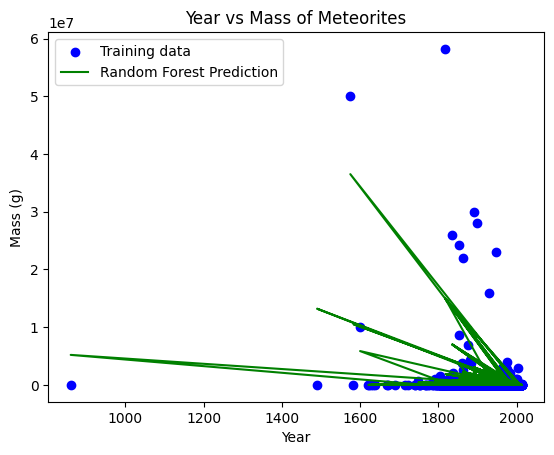

In [23]:
# Plot the results
plt.scatter(X_train, Y_train, color='blue', label='Training data')
plt.plot(X_train, model.predict(X_train), color='green', label='Random Forest Prediction')
plt.xlabel('Year')
plt.ylabel('Mass (g)')
plt.title('Year vs Mass of Meteorites')
plt.legend()
plt.show()

In [24]:
input_year = np.array([[2000]])
predicted_mass = model.predict(input_year)
print(predicted_mass)


[2108.65667718]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
